__The purpose of this notebook is to build an intuition for what the ocean looks like - what the boundaries are and what the physical properties of sea water look like by exploring observational data.__ 

Here we will use the long-term average ocean properties observed in the global ocean using the World Ocean Atlas 18 gridded dataset ([Boyer et al., 2018](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)) hosted by NOAA's National Centers for Environmental Information (NCEI) and based on data in the World Ocean Database (WOD).

From www.ncei.noaa.gov: _The World Ocean Atlas (WOA) is a collection of gridded, quality controlled temperature, salinity, oxygen, phosphate, silicate, and nitrate means on standard depth levels based on profile data from the World Ocean Database (WOD). It can be used to create boundary and/or initial conditions for a variety of ocean models, verify numerical simulations of the ocean, and corroborate satellite data._

The WOA is published semi-regulary since 1994 and is based off of the ground breaking Climatological Atlas of the World Ocean published by NOAA scientist Sydney Levitus in 1982 (while at NOAA's Geophysical Fluid Dynamics Laboratory). __The WOA is one of the most widely used datasets in oceanography and climate science__.

![](https://books.google.com/books/content?id=_x0IAQAAIAAJ&pg=PR1&img=1&zoom=3&hl=en&sig=ACfU3U1UpmEg019E4PriRYiyjSzvlagEDQ&w=1025)

##### The gridded WOA observational product is used for:
* the development and evaluation of ocean models.
* the development and evaluation of fully coupled climate models.
* providing __initial conditions__ for climate model simulations.
* verification of ocean surface properties against satellite observations.
* planning oceanographic expeditions and observational campaigns.
* assessing physical and biogeochemical properties in the ocean and their change.

#### Authors: Dr. Rebecca L. Beadling. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu.

#### Load in our packages, set up the notebook, and read in the data. Here we will load in WOA18 data and also the ETOPO5 land surface elevations and sea floor depth dataset.

In [1]:
import xarray as xr
import cmocean 
import matplotlib.pyplot as plt
import cftime
import numpy as np

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6

In [3]:
woa18_data = xr.open_zarr('/home/tu.temple.edu/tuq41374/courses/EES3506_5506_Fall2023_Unit6/data/woa18/woa18_full_decadal_ave_fields/')

etopo5_data = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
etopo5_data = etopo5_data.rename({'X': 'lon', 'Y': 'lat'})
etopo5_data['elev_ocean'] = etopo5_data.elev.where(etopo5_data.elev<0).load()
etopo5_data

<xarray.Dataset> Size: 56MB
Dimensions:     (lon: 4320, lat: 2160)
Coordinates:
  * lon         (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
  * lat         (lat) float32 9kB 90.0 89.92 89.83 ... -89.75 -89.83 -89.92
Data variables:
    elev        (lat, lon) int16 19MB -4290 -4290 -4290 -4290 ... 2774 2774 2774
    elev_ocean  (lat, lon) float32 37MB -4.29e+03 -4.29e+03 ... nan nan
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

In [4]:
woa18_data

<xarray.Dataset> Size: 106MB
Dimensions:   (depth: 102, lat: 180, lon: 360)
Coordinates:
  * depth     (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    nitrate   (depth, lat, lon) float32 26MB dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    oxygen    (depth, lat, lon) float32 26MB dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    salinity  (depth, lat, lon) float32 26MB dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    temp      (depth, lat, lon) float32 26MB dask.array<chunksize=(26, 45, 180), meta=np.ndarray>

In [5]:
etopo5_data

<xarray.Dataset> Size: 56MB
Dimensions:     (lon: 4320, lat: 2160)
Coordinates:
  * lon         (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
  * lat         (lat) float32 9kB 90.0 89.92 89.83 ... -89.75 -89.83 -89.92
Data variables:
    elev        (lat, lon) int16 19MB -4290 -4290 -4290 -4290 ... 2774 2774 2774
    elev_ocean  (lat, lon) float32 37MB -4.29e+03 -4.29e+03 ... nan nan
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

#### Define variables of interest

In [6]:
temp = woa18_data.temp
salt = woa18_data.salinity
elev = etopo5_data.elev
elev_ocean = etopo5_data.elev_ocean

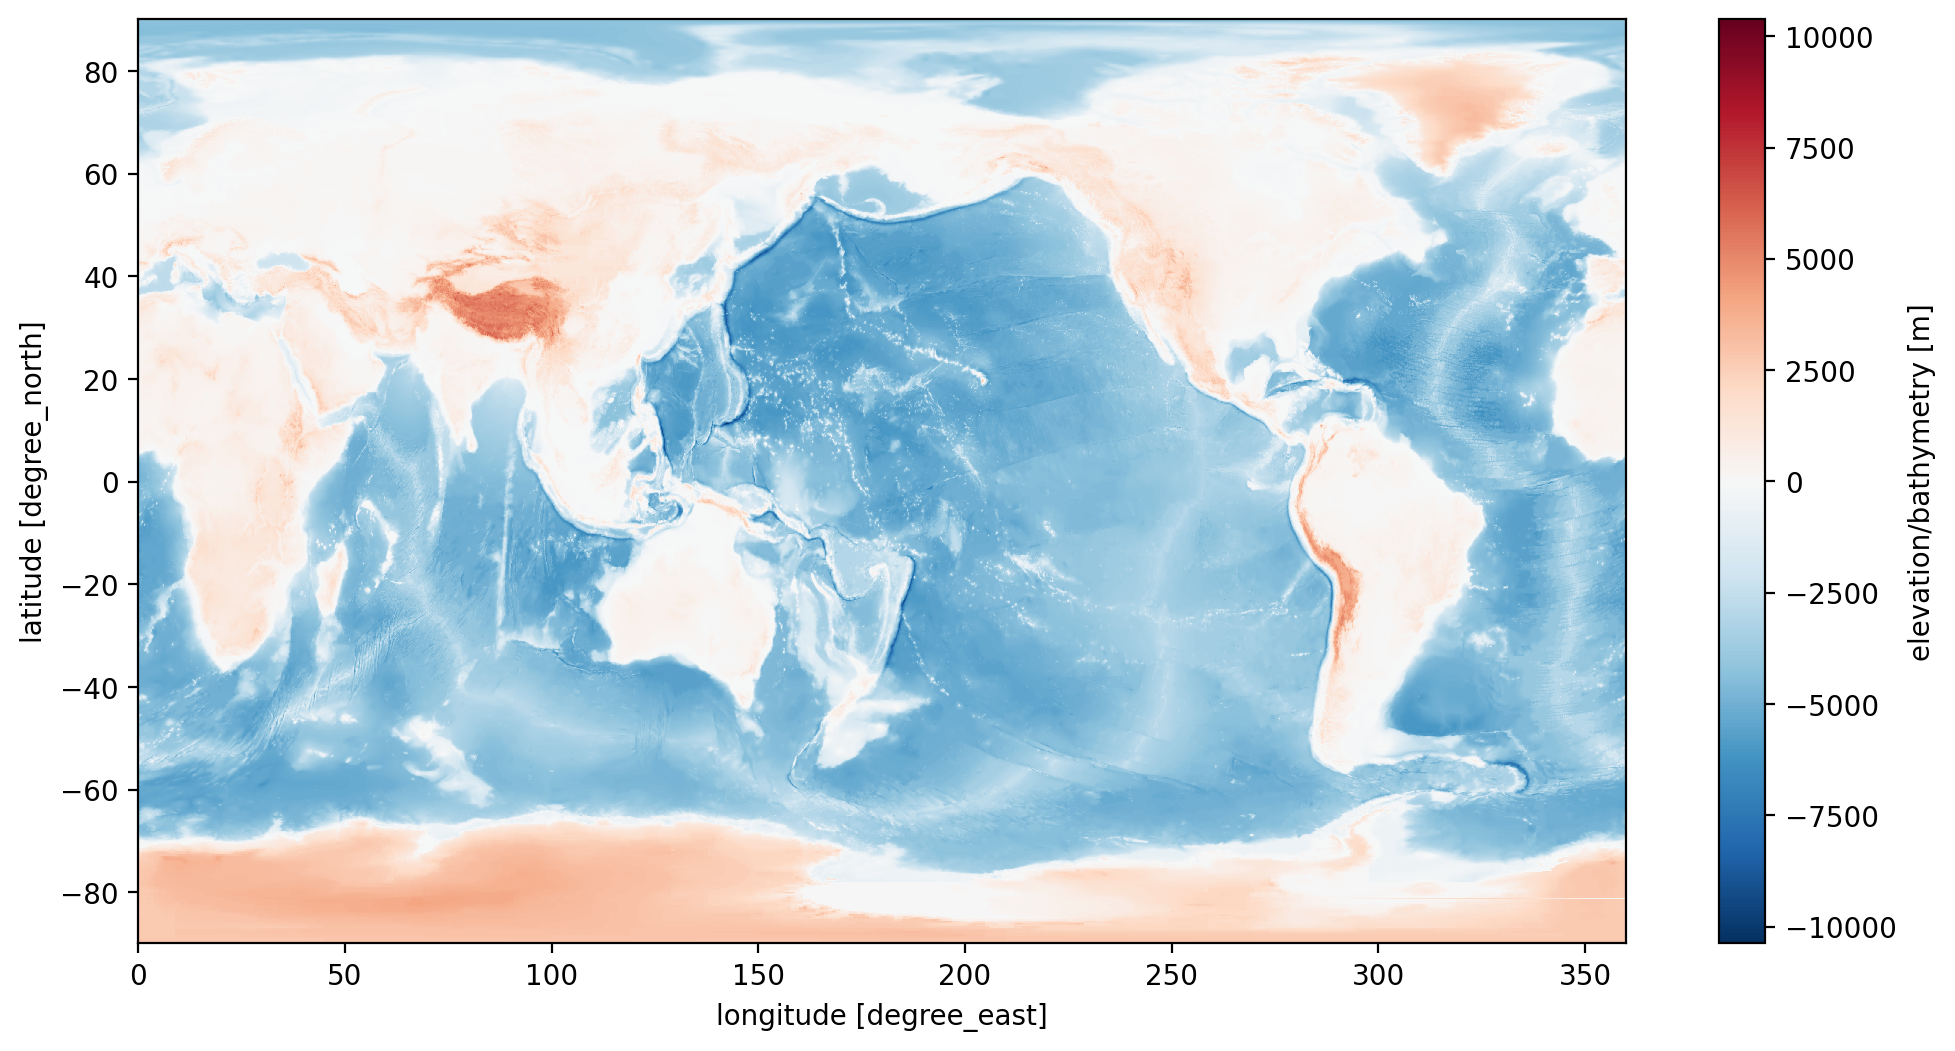

In [7]:
elev.plot()

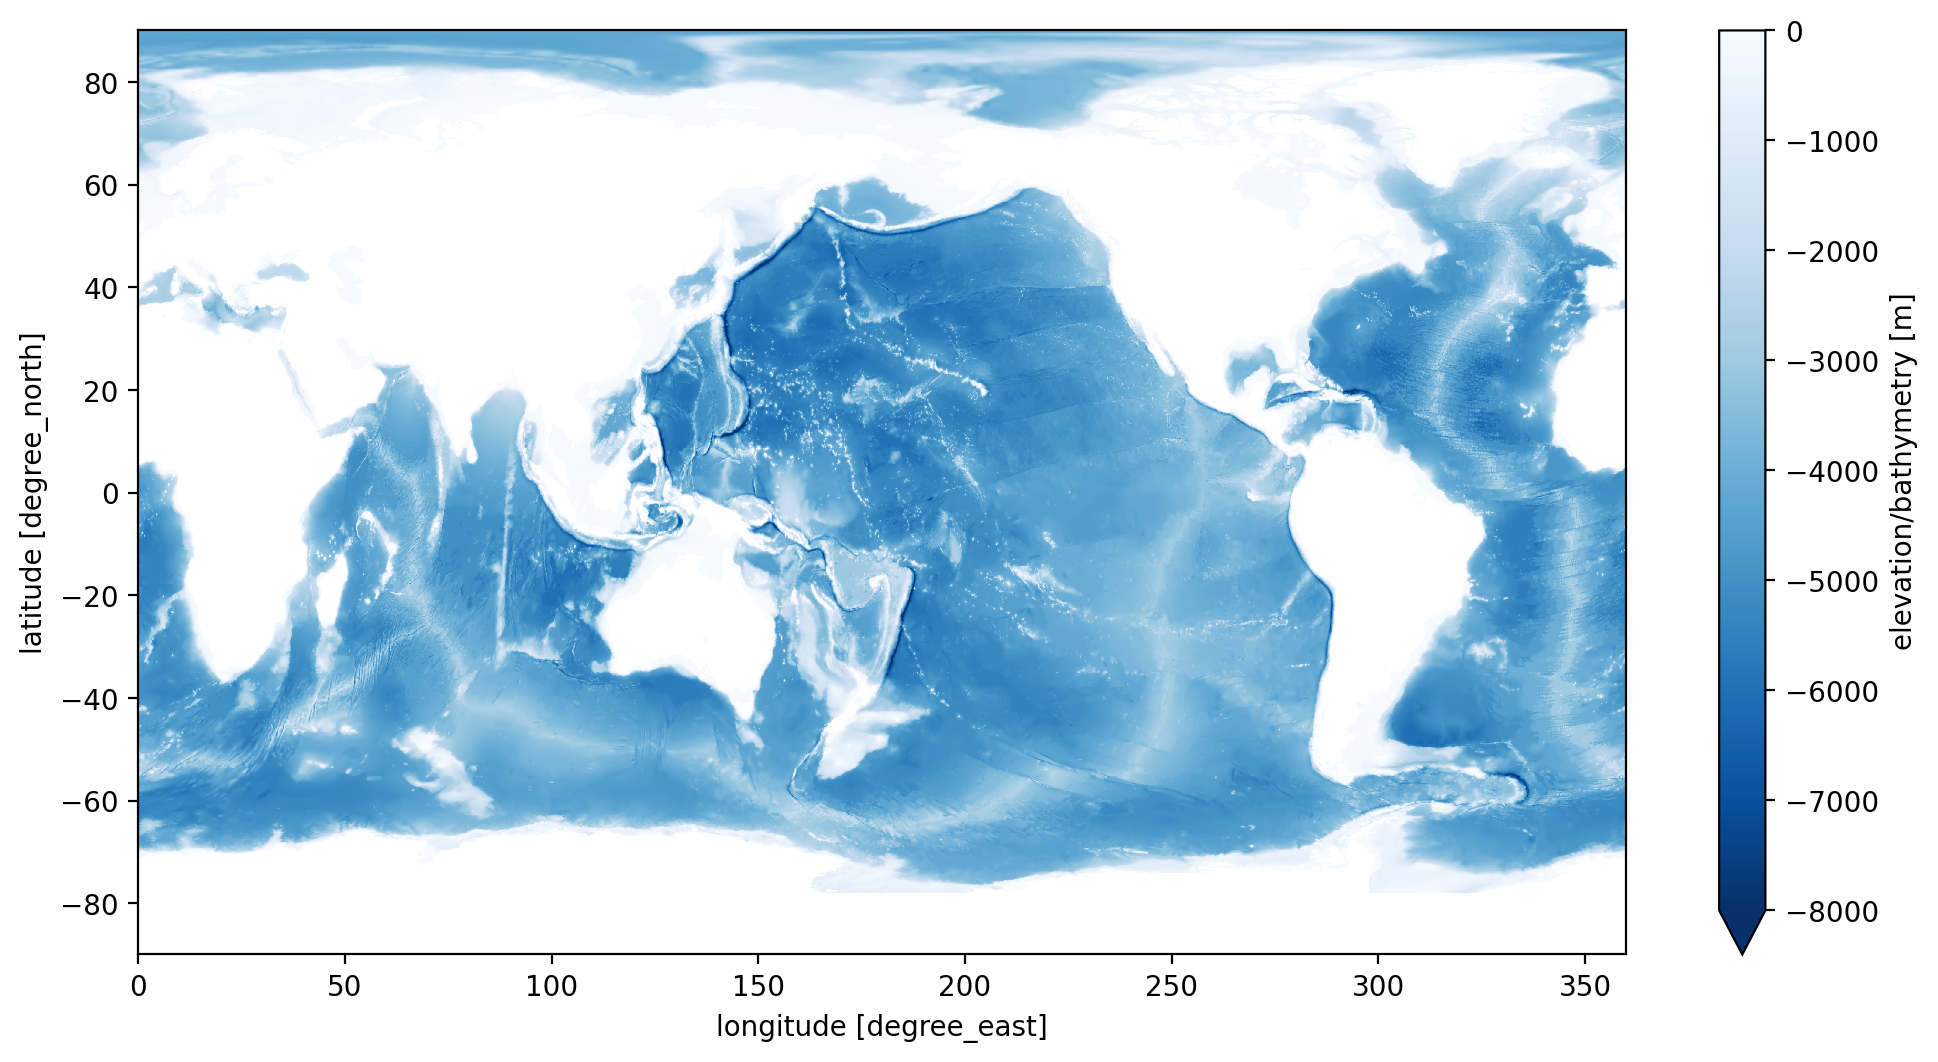

In [8]:
elev_ocean.plot(cmap='Blues_r',vmin=-8000,vmax=0)

#### I told you in lecture 2 that the ocean occupies ~71% of Earth's total surface area - is that true? What is Earth's surface area?

In [9]:
r_earth = 6371.0e3

In [10]:
SA_earth = 4*np.pi*(r_earth**2)

In [11]:
SA_earth

510064471909788.25

#### We can write a basic function to compute grid cell area in m2 given a datasets lat, lon coordinate label values.

In [12]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

In [13]:
lat_elev = elev.coords['lat'].values #1-D numpy array of model's latitude values
lon_elev = elev.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_elev,lon_elev) 

In [14]:
# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original array:

areacell_xarray = xr.DataArray(areacell,dims=({'lat':2160, 'lon':4320}),\
                                                coords=(elev.coords['lat'],\
                                                        elev.coords['lon']))

In [15]:
areacell_xarray

<xarray.DataArray (lat: 2160, lon: 4320)> Size: 75MB
array([[6.55422786e-06, 6.55422786e-06, 6.55422786e-06, ...,
        6.55422786e-06, 6.55422786e-06, 6.55422786e-06],
       [1.24890632e+05, 1.24890632e+05, 1.24890632e+05, ...,
        1.24890632e+05, 1.24890632e+05, 1.24890632e+05],
       [2.49769567e+05, 2.49769567e+05, 2.49769567e+05, ...,
        2.49769567e+05, 2.49769567e+05, 2.49769567e+05],
       ...,
       [3.74659406e+05, 3.74659406e+05, 3.74659406e+05, ...,
        3.74659406e+05, 3.74659406e+05, 3.74659406e+05],
       [2.49781000e+05, 2.49781000e+05, 2.49781000e+05, ...,
        2.49781000e+05, 2.49781000e+05, 2.49781000e+05],
       [1.24890632e+05, 1.24890632e+05, 1.24890632e+05, ...,
        1.24890632e+05, 1.24890632e+05, 1.24890632e+05]])
Coordinates:
  * lat      (lat) float32 9kB 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon      (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9

#### If we sum up all of our gridcell areas, we should now arrive at a value close to our original surface area of the Earth we calculated above - is this correct?

In [27]:
SA_earth = areacell_xarray.sum(dim=['lat','lon'])

#### Great, now lets isolate the area ONLY of the ocean:

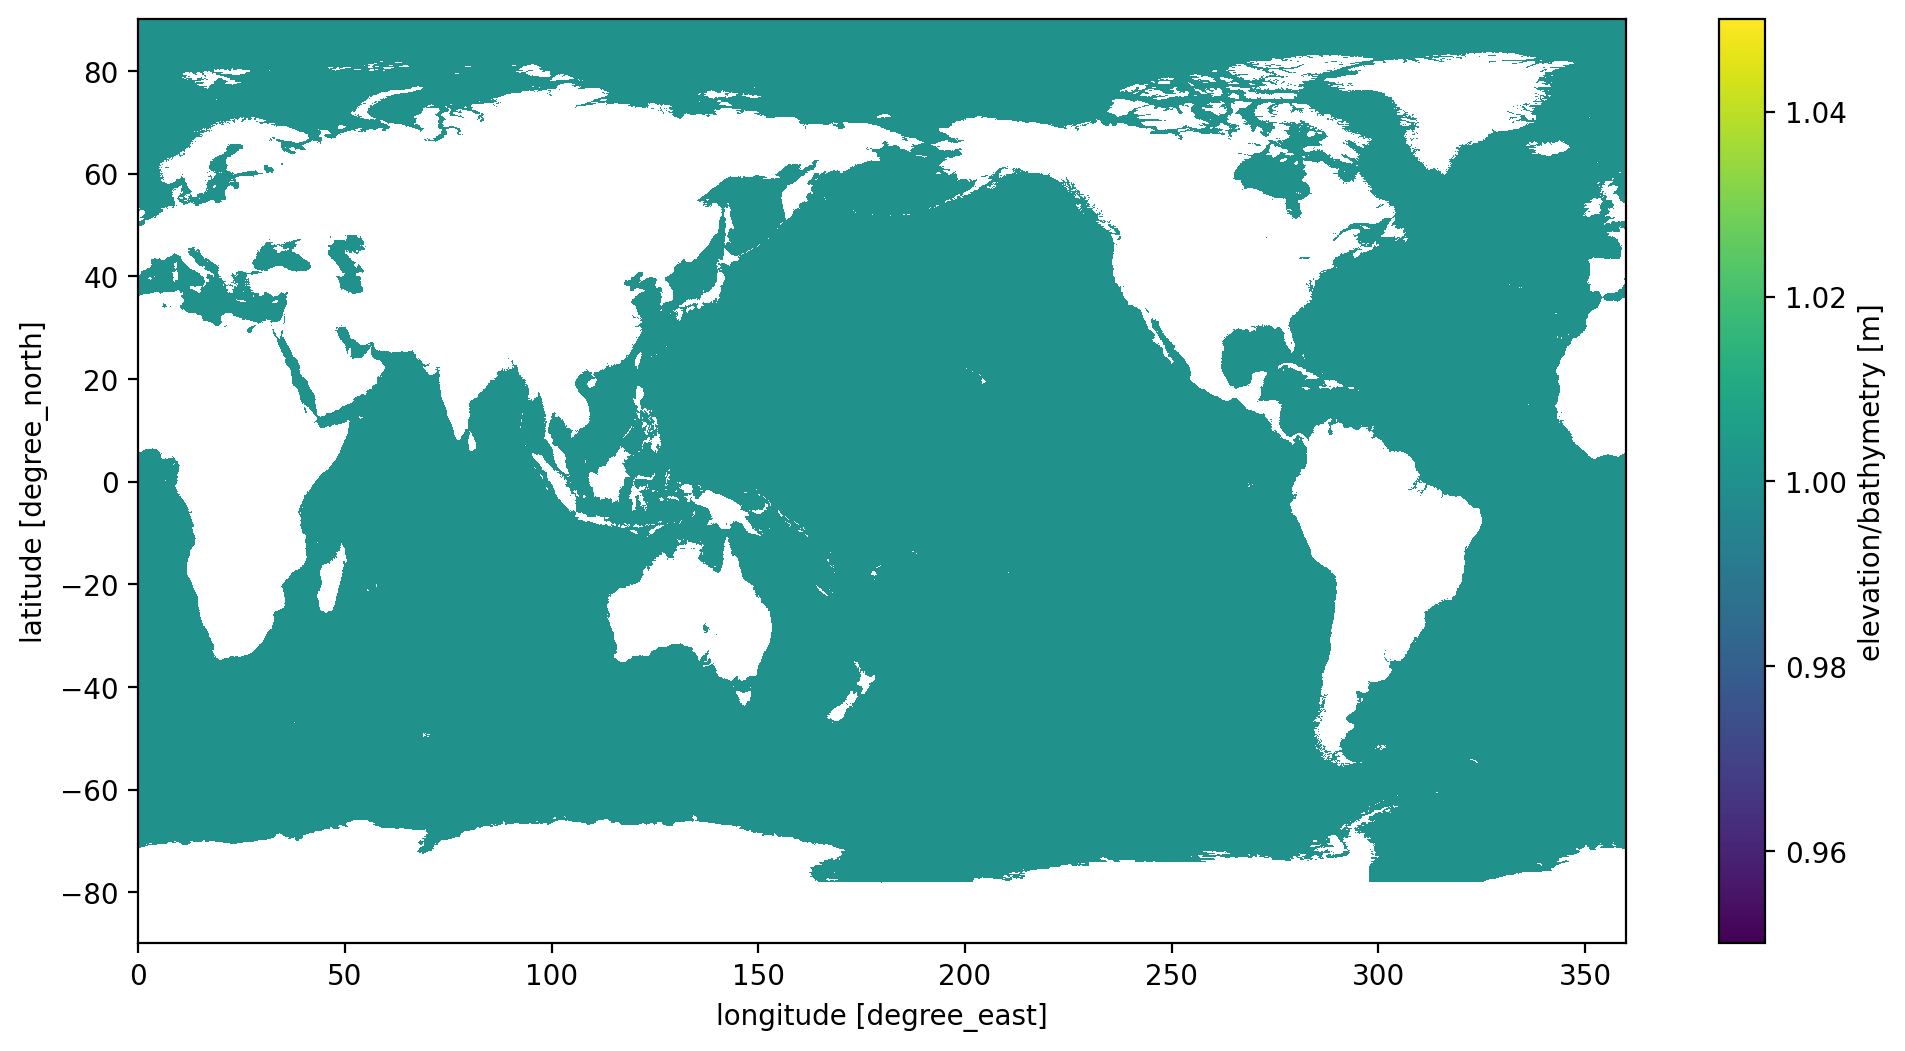

In [28]:
ocean_only = elev_ocean.where(elev_ocean.isnull(), 1)
ocean_only.plot()

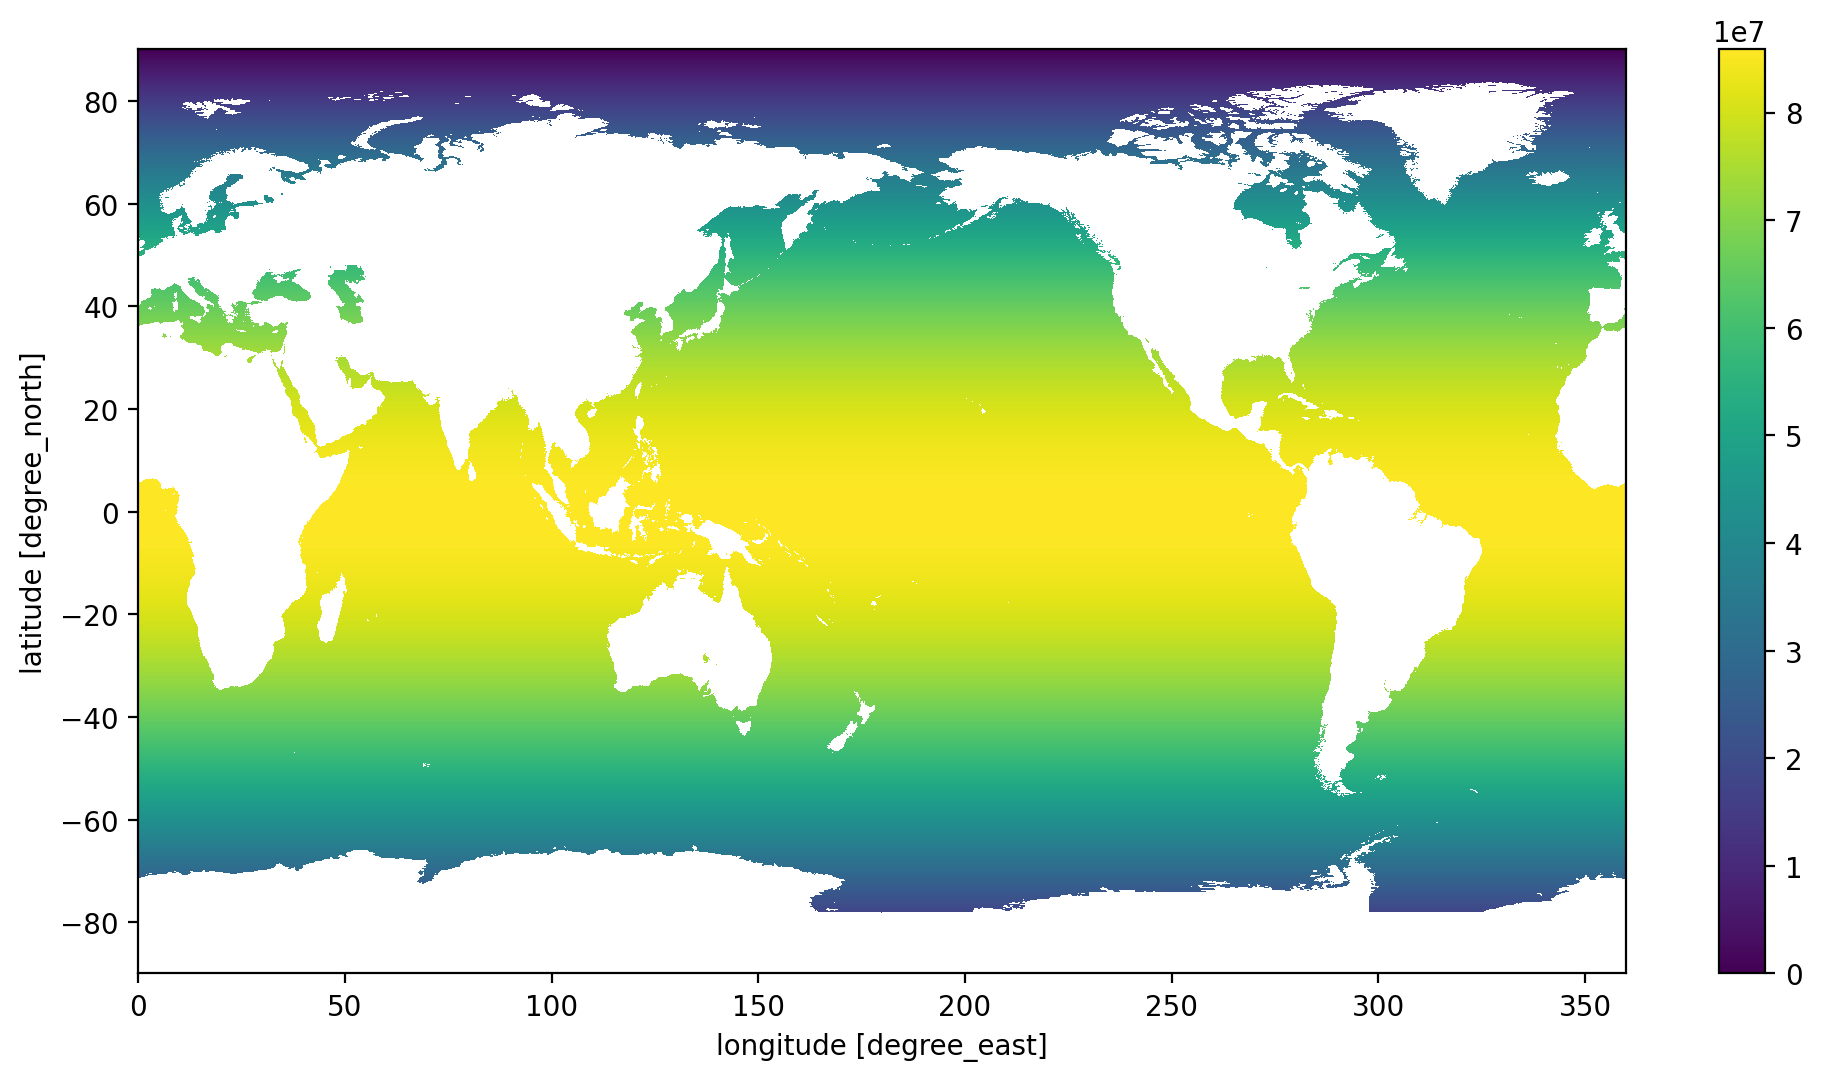

In [30]:
ocean_area = (areacell_xarray*ocean_only)
ocean_area.plot()

#### Compute the percent coverage of Earth's surface by the ocean:

In [31]:
ocean_coverage = (ocean_area.sum() / SA_earth)*100

In [32]:
ocean_coverage

<xarray.DataArray ()> Size: 8B
array(71.39352607)

#### Let's calculate some basic quantities using our ocean depth array

In [33]:
deepest = float(elev_ocean.min().values)
shallowest = float(elev_ocean.max().values)

weights = ocean_area.fillna(0)
average_depth = float(elev_ocean.weighted(weights).mean().values)
ocean_volume = float(elev_ocean.weighted(weights).sum().values*-1)

In [34]:
print('The deepest part of the ocean is', deepest, 'm')
print('The shallowest part of the ocean is', shallowest, 'm')
print('The average depth of the ocean is', average_depth, 'm')
print('The volume of the ocean is', ocean_volume, 'm')

The deepest part of the ocean is -10376.0 m
The shallowest part of the ocean is -1.0 m
The average depth of the ocean is -3674.6555473758563 m
The volume of the ocean is 1.3381773099938644e+18 m


#### How is depth distributed in the global ocean? Let's produce an area-weighted distribution of elevation everywhere.

(-8000.0, 6000.0)

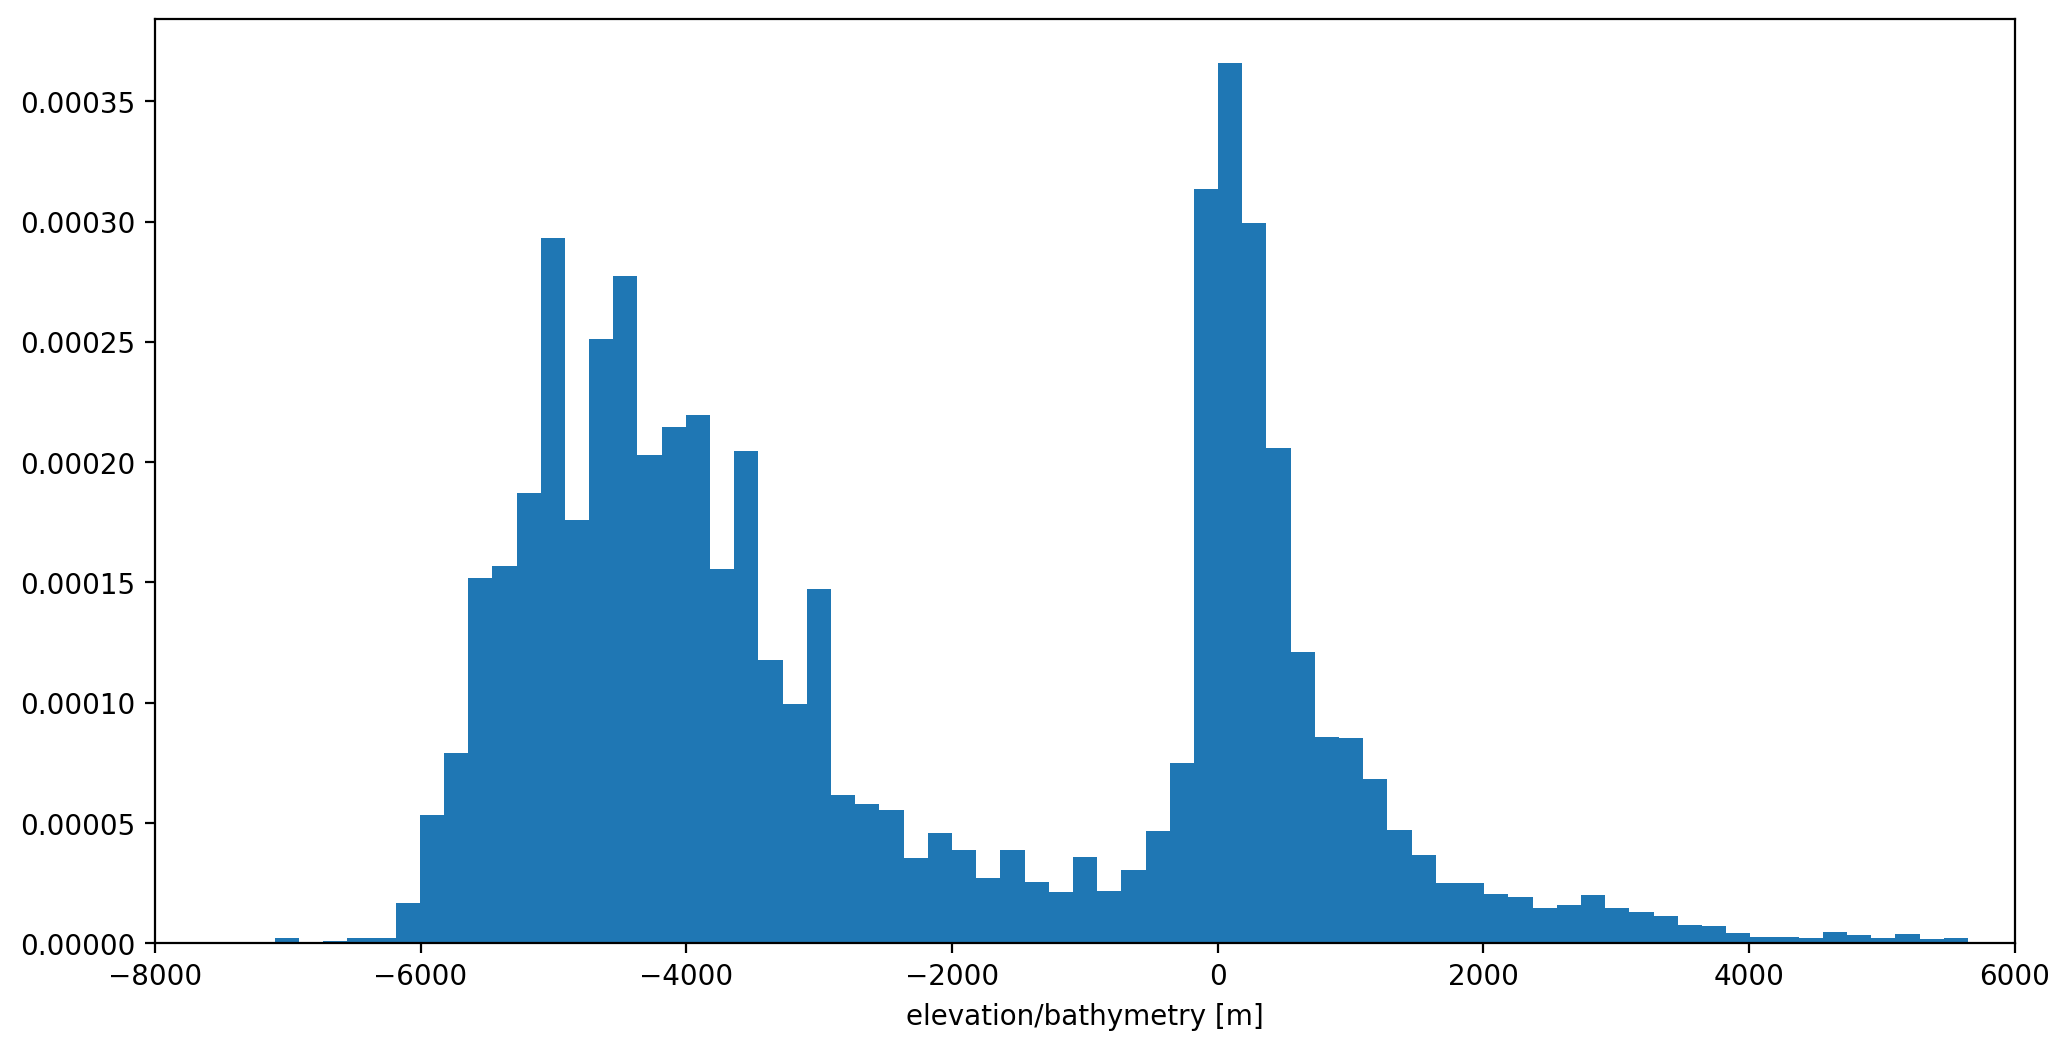

In [35]:
## Produce area-weighted distribution of elevation around the globe. The density=True normalizes
## it such that the total area under the curve (the histogram) sumes to 1.

fig, ax = plt.subplots()
elev.plot.hist(bins=100, weights=areacell_xarray.values.ravel(), density=True) ## count the number of depths that fall into 100 bins
ax.set_xlim([-8000,6000])

#### Great --- so that is what the ocean looks like spatially. There is much more you can do with this notebook, e.g, explore depth in a given ocean basin, etc.

#### Let's explore the __pressure, temperature, salinity, and density__ structure of the ocean.

WOA provides its product on standard depth levels, not pressure. We can use the Gibbs SeaWater Oceanographic Toolbox python package (gsw) to convert depth to pressure. The gsw package uses the International Thermodynamic Equation of SeaWater - 2010 (TEOS-10). 

See here for a description of the gsw toolbox: https://teos-10.github.io/GSW-Python/

See here for the full description of TEOS-10: https://www.teos-10.org/pubs/gsw/pdf/TEOS-10_Manual.pdf



In [39]:
import gsw

In [40]:
help(gsw.p_from_z)

Help on function p_from_z in module gsw._fixed_wrapped_ufuncs:

p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)
    Calculates sea pressure from height using computationally-efficient
    75-term expression for density, in terms of SA, CT and p (Roquet et al.,
    2015).  Dynamic height anomaly, geo_strf_dyn_height, if provided,
    must be computed with its p_ref = 0 (the surface). Also if provided,
    sea_surface_geopotental is the geopotential at zero sea pressure. This
    function solves Eqn.(3.32.3) of IOC et al. (2010) iteratively for p.
    
    Parameters
    ----------
    z : array-like
        Depth, positive up, m
    lat : array-like
        Latitude, -90 to 90 degrees
    geo_strf_dyn_height : array-like
        dynamic height anomaly, m^2/s^2
            Note that the reference pressure, p_ref, of geo_strf_dyn_height must
            be zero (0) dbar.
    sea_surface_geopotential : array-like
        geopotential at zero sea pressure,  m^2/s^2
    


In [41]:
depth = woa18_data.depth
pressure = (gsw.p_from_z(-depth, woa18_data.lat))#.rename({'depth':'pressure'})

ds_pressure = xr.Dataset()
ds_pressure["pressure"] = pressure
ds_pressure.pressure.sel(depth=1000,method='nearest')

<xarray.DataArray 'pressure' (lat: 180)> Size: 1kB
array([1013.32094206, 1013.31766494, 1013.31111473, 1013.30129952,
       1013.28823143, 1013.27192658, 1013.2524051 , 1013.22969107,
       1013.20381253, 1013.17480138, 1013.14269343, 1013.10752827,
       1013.06934927, 1013.0282035 , 1012.98414167, 1012.93721809,
       1012.88749059, 1012.83502041, 1012.77987218, 1012.7221138 ,
       1012.66181637, 1012.59905409, 1012.53390418, 1012.46644674,
       1012.39676473, 1012.32494378, 1012.25107213, 1012.17524051,
       1012.09754202, 1012.01807203, 1011.93692802, 1011.85420951,
       1011.77001789, 1011.68445634, 1011.59762965, 1011.50964412,
       1011.42060745, 1011.33062853, 1011.23981741, 1011.14828506,
       1011.05614331, 1010.96350468, 1010.87048224, 1010.77718947,
       1010.68374016, 1010.59024819, 1010.49682748, 1010.4035918 ,
       1010.31065463, 1010.21812905, 1010.12612757, 1010.03476204,
       1009.94414345, 1009.85438188, 1009.76558627, 1009.67786437,
       1009.59132258, 1009.50606581, 1009.42219738, 1009.33981888,
       1009.25903005, 1009.17992868, 1009.10261046, 1009.02716889,
       1008.95369519, 1008.88227814, 1008.81300401, 1008.74595645,
       1008.68121641, 1008.61886201, 1008.55896848, 1008.50160805,
       1008.44684988, 1008.39475997, 1008.34540108, 1008.29883269,
       1008.25511087, 1008.21428828, 1008.17641406, 1008.14153381,
...
       1008.14153381, 1008.17641406, 1008.21428828, 1008.25511087,
       1008.29883269, 1008.34540108, 1008.39475997, 1008.44684988,
       1008.50160805, 1008.55896848, 1008.61886201, 1008.68121641,
       1008.74595645, 1008.81300401, 1008.88227814, 1008.95369519,
       1009.02716889, 1009.10261046, 1009.17992868, 1009.25903005,
       1009.33981888, 1009.42219738, 1009.50606581, 1009.59132258,
       1009.67786437, 1009.76558627, 1009.85438188, 1009.94414345,
       1010.03476204, 1010.12612757, 1010.21812905, 1010.31065463,
       1010.4035918 , 1010.49682748, 1010.59024819, 1010.68374016,
       1010.77718947, 1010.87048224, 1010.96350468, 1011.05614331,
       1011.14828506, 1011.23981741, 1011.33062853, 1011.42060745,
       1011.50964412, 1011.59762965, 1011.68445634, 1011.77001789,
       1011.85420951, 1011.93692802, 1012.01807203, 1012.09754202,
       1012.17524051, 1012.25107213, 1012.32494378, 1012.39676473,
       1012.46644674, 1012.53390418, 1012.59905409, 1012.66181637,
       1012.7221138 , 1012.77987218, 1012.83502041, 1012.88749059,
       1012.93721809, 1012.98414167, 1013.0282035 , 1013.06934927,
       1013.10752827, 1013.14269343, 1013.17480138, 1013.20381253,
       1013.22969107, 1013.2524051 , 1013.27192658, 1013.28823143,
       1013.30129952, 1013.31111473, 1013.31766494, 1013.32094206])
Coordinates:
    depth    float32 4B 1e+03
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    axis:           Z
    bounds:         depth_bnds
    positive:       down
    standard_name:  depth
    units:          meters

#### What is the pressure at 1000 m depth at a given latitude, let's choose the equator. Is it equal to 1000 ?

In [42]:
ds_pressure.pressure.sel(depth=1000,method='nearest',lat=0)

<xarray.DataArray 'pressure' ()> Size: 8B
array(1007.96479084)
Coordinates:
    depth    float32 4B 1e+03
    lat      float32 4B 0.5
Attributes:
    axis:           Z
    bounds:         depth_bnds
    positive:       down
    standard_name:  depth
    units:          meters

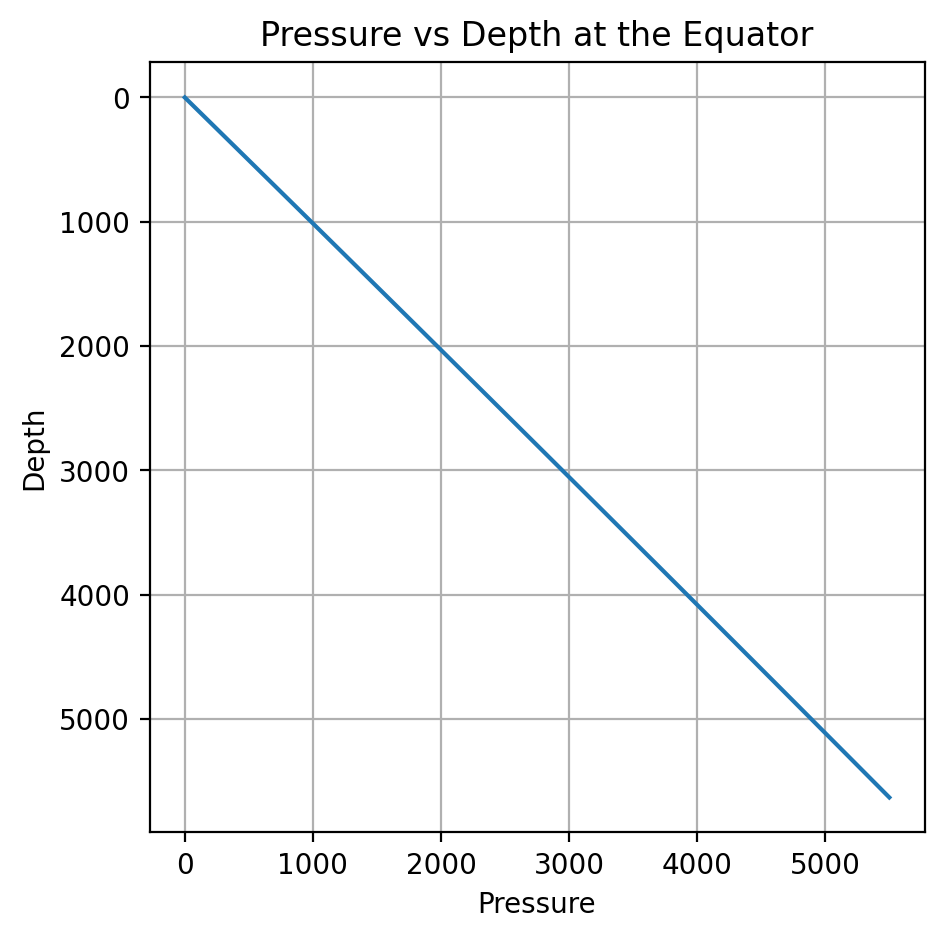

In [76]:
fig, ax = plt.subplots(figsize=(5,5))
ds_pressure.pressure.isel(lat=0).plot(ax=ax)

plt.xlabel('Pressure')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # Optional: if you want depth increasing downward (common in geoscience)
plt.title('Pressure vs Depth at the Equator')
plt.grid(True)
plt.show()

#### <font color=red> Why is depth not equal to pressure? For a given latitude, explore the nature of this divergence as a function of depth in the water column. What do you notice? What's the explanation?

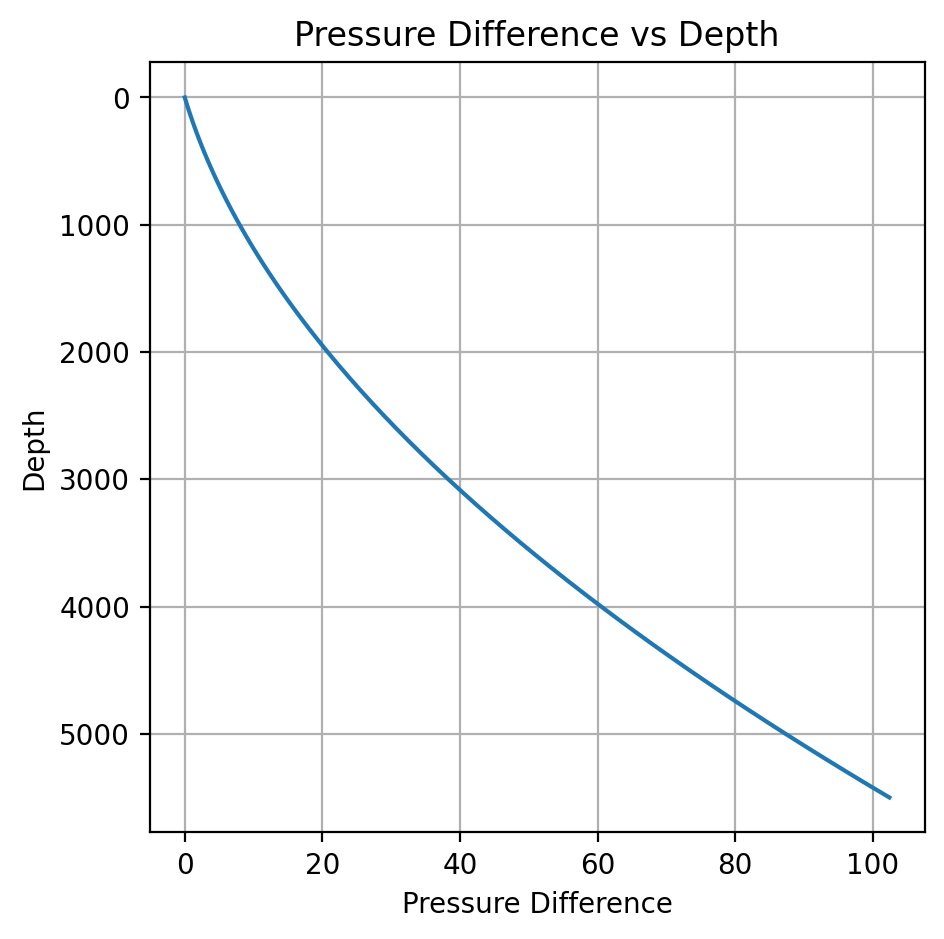

In [77]:
pressure_eq = ds_pressure.pressure.sel(method='nearest',lat=0)
depth = ds_pressure.depth

difference = pressure_eq - depth

fig, ax = plt.subplots(figsize=(5,5))

plt.plot(difference, depth)
plt.xlabel('Pressure Difference')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  
plt.title('Pressure Difference vs Depth')
plt.grid(True)
plt.show()

#### Recall that the relationship of **hydrostatic balance** is given by the following equation which states that the pressure at a given depth ($z$) is a function of the mass of water (or air in the case of the atmosphere) above it:


$$
p(z) = g \int_z^0 \rho(z') \, dz'
$$

$$
\frac{\partial p}{\partial z} = - \rho g
$$

#### where:

- \( $p$ \) is pressure at a given depth (or height),
- \( $z$ \) is the vertical height,
- \( $\rho$) is the sea water density,
- \( $g$ \) is the acceleration due to gravity.

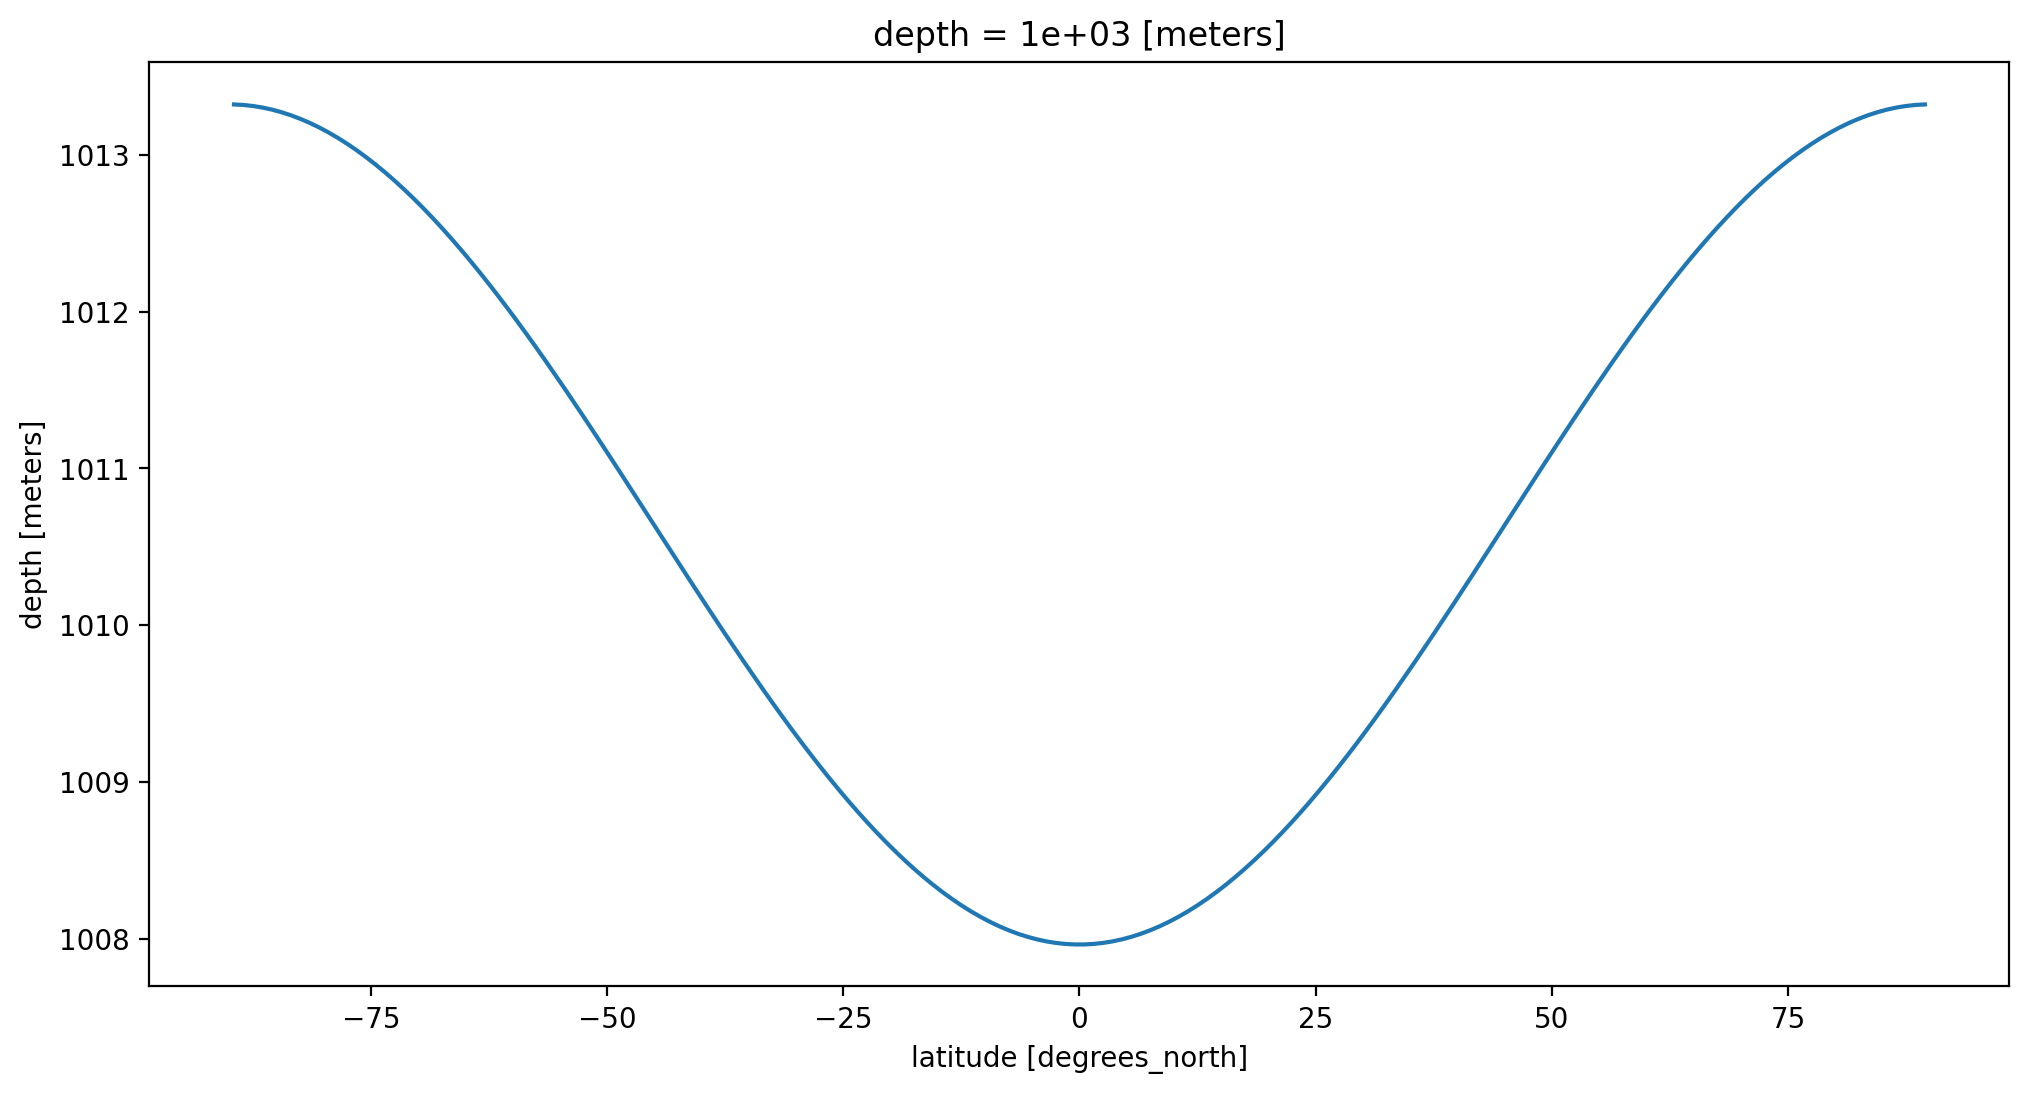

In [196]:
ds_pressure.pressure.sel(depth=1000).plot()

#### <font color=red> </font><br /><font color=red> Why does the deviation of pressure from depth vary with respect to latitude? The difference is smallest at the equator, but gets larger toward the poles. Why?</font><br />

The equation below is the one that is being solved by the `gsw.p_from_z` function (see https://www.teos-10.org/pubs/TEOS-10_Manual.pdf).

$$
h^{75} \bigl( S_{SO}\, , 0^\circ \mathrm{C}, p \bigr) - \Psi - \Phi^0 + g(\phi,0)( z - \frac{1}{2} \gamma z^2) = 0.
$$

![](https://www.physicsforums.com/insights/wp-content/uploads/2016/01/Earth_surfacegravity_lge.jpg)